In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
dataset = 'macosko2015'
dims = (50)
n_components = 64

In [7]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [8]:
import gzip
import pickle

with gzip.open(DATA_DIR / 'macosko_2015.pkl.gz', "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

def zero_one_norm(x):
    return (x- np.min(x, axis=0))/ (np.max(x, axis=0)-np.min(x, axis=0))

x_norm = zero_one_norm(x)

print("Data set contains %d samples with %d features" % x.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_norm, y, test_size=.1, random_state=42)

n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

X_train_flat = X_train
X_test_flat = X_test

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

Y_train = enc.fit_transform([[i] for i in Y_train]).flatten()
Y_test = enc.fit_transform([[i] for i in Y_test]).flatten()

Data set contains 44808 samples with 50 features


### define networks

In [9]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(
    tf.keras.layers.Dense(units=n_components, name="z")
)

In [10]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=50, activation="sigmoid"),
])

In [11]:
input_img = tf.keras.Input(dims)
output_img = decoder(encoder(input_img))
autoencoder = tf.keras.Model(input_img, output_img)

In [12]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
#X_train = X_train.reshape([len(X_train)] + list(dims))
history = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                #validation_data=(X_valid, X_valid)
                         )

Epoch 1/50
119/119 [==============================] - 0s 3ms/step - loss: 0.6187
Epoch 2/50
119/119 [==============================] - 0s 3ms/step - loss: 0.6116
Epoch 3/50
119/119 [==============================] - 0s 4ms/step - loss: 0.6109
Epoch 4/50
119/119 [==============================] - 1s 5ms/step - loss: 0.6106
Epoch 5/50
119/119 [==============================] - 1s 5ms/step - loss: 0.6103
Epoch 6/50
119/119 [==============================] - 1s 5ms/step - loss: 0.6101
Epoch 7/50
119/119 [==============================] - 0s 3ms/step - loss: 0.6100
Epoch 8/50
119/119 [==============================] - 0s 3ms/step - loss: 0.6099
Epoch 9/50
119/119 [==============================] - 0s 3ms/step - loss: 0.6098
Epoch 10/50
119/119 [==============================] - 0s 4ms/step - loss: 0.6097
Epoch 11/50
119/119 [==============================] - 0s 3ms/step - loss: 0.6096
Epoch 12/50
119/119 [==============================] - 0s 4ms/step - loss: 0.6095
Epoch 13/50
119/119 [====

In [14]:
z = encoder.predict(X_train)

### Plot model output

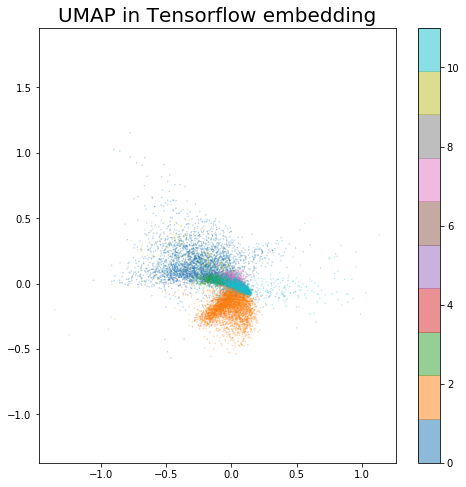

In [15]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)].flatten(),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [16]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

### Save output

In [ ]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [ ]:
output_dir = MODEL_DIR/'projections'/ dataset / '64' / 'ae_only'
ensure_dir(output_dir)

In [ ]:
encoder.save(output_dir / 'encoder')

In [ ]:
decoder.save(output_dir / 'encoder')

In [ ]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [ ]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [23]:
X_test.shape

(4481, 50)

In [24]:
X_test_flat.shape

(4481, 50)

In [25]:
z_test = encoder.predict(X_test.reshape((len(X_test), 50)))

In [26]:
z_test.shape

(4481, 64)

#### silhouette

In [27]:
from tfumap.silhouette import silhouette_score_block

In [28]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.42886058473367683

In [29]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.44128636573426416

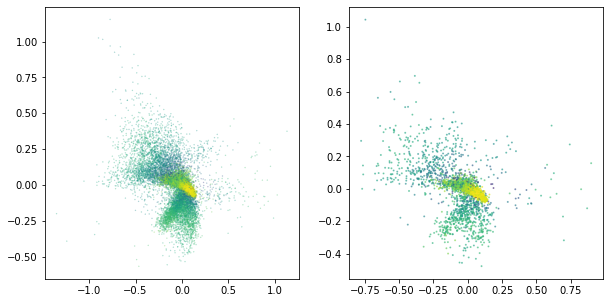

In [30]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train.flatten())
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.9817005132782861

In [33]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.9750055791118054

#### Trustworthiness

In [34]:
from sklearn.manifold import trustworthiness

In [35]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [36]:
X_test_flat.shape, z_test.shape

((4481, 50), (4481, 64))

In [37]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [38]:
tw, tw_test

(0.9921497698158527, 0.9896483016724663)

### Save output metrics

In [39]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#### train

In [40]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'ae_only', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,macosko2015,ae_only,64,0.99215,0.428861,"[0.5916499102889315, 0.46614816735679715, 0.17..."


In [41]:
save_loc = DATA_DIR / 'projection_metrics' /  'ae_only' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### test

In [42]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'ae_only', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,macosko2015,ae_only,64,0.989648,0.441286,"[0.596852233566655, -0.17140138069168886, 0.66..."


In [43]:
save_loc = DATA_DIR / 'projection_metrics' / 'ae' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [44]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['ae_only', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,ae_only,64,macosko2015,0.975006,0.981701


In [45]:
save_loc = DATA_DIR / 'knn_classifier' / 'ae_only' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Reconstruction

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [47]:
X_recon = decoder.predict(encoder.predict(X_test.reshape((len(X_test), 50))))
X_real = X_test.reshape((len(X_test), 50))

In [48]:
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [49]:
reconstruction_acc_df = pd.DataFrame(
    columns=["method_", "dimensions", "dataset", "MSE", "MAE", "MedAE", "R2"]
)

In [ ]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['ae_only', 64, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

In [ ]:
save_loc = DATA_DIR / 'reconstruction_acc' / 'ae_only' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
reconstruction_acc_df.to_pickle(save_loc)

### Compute clustering quality

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [53]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    if save_loc.exists() and save_loc.is_file():
        
        cluster_df = pd.read_pickle(save_loc)
        return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                y, clustered_y
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [54]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, 'ae_only', z, Y_train.flatten(), n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,macosko2015,ae_only,"[[-0.002685447, -0.012795519, -0.022101441, -0...","[10.0, 7.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0,...",64


In [ ]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/ae_only_64_macosko2015.pickle
